In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import utils
plt.ion()   # interactive mode

In [2]:
from torchvision.models import MobileNet_V3_Large_Weights

In [3]:
torch.cuda.is_available()

True

In [4]:
device=torch.device('cuda')
print(f"Using {device} device")

Using cuda device


In [5]:
cudnn.enabled = True

In [6]:
cudnn.benchmark = True

In [8]:
transforms = {
    'train': v2.Compose([
        v2.AutoAugment(),
        v2.Resize(232),
        v2.CenterCrop(224),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        v2.RandomErasing(p=0.2)
    ]),
    'val': v2.Compose([
        v2.AutoAugment(),
        v2.Resize(232),
        v2.CenterCrop(224),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        v2.RandomErasing(p=0.2)
    ]),
}

In [9]:
transforms

{'train': Compose(
       Resize(size=[232], interpolation=InterpolationMode.BILINEAR, antialias=True)
       CenterCrop(size=(224, 224))
       PILToTensor()
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 'val': Compose(
       Resize(size=[232], interpolation=InterpolationMode.BILINEAR, antialias=True)
       CenterCrop(size=(224, 224))
       PILToTensor()
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 )}

In [10]:
data_="data"

In [11]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_, x),transforms[x]) for x in ['train', 'val']}

In [28]:
image_datasets['train'].classes

['F-15 Eagle',
 'F-22 Raptor',
 'a-10 thunderbolt ii',
 'ac-130 ghostrider',
 'b-1 lancer',
 'b-2 spirit',
 'b-52 stratofortress',
 'f-35 lightning ii']

In [12]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,shuffle=True, num_workers=4)for x in ['train', 'val']}

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [14]:
class_names = image_datasets['train'].classes

In [15]:
class_names

['F-15 Eagle',
 'F-22 Raptor',
 'a-10 thunderbolt ii',
 'ac-130 ghostrider',
 'b-1 lancer',
 'b-2 spirit',
 'b-52 stratofortress',
 'f-35 lightning ii']

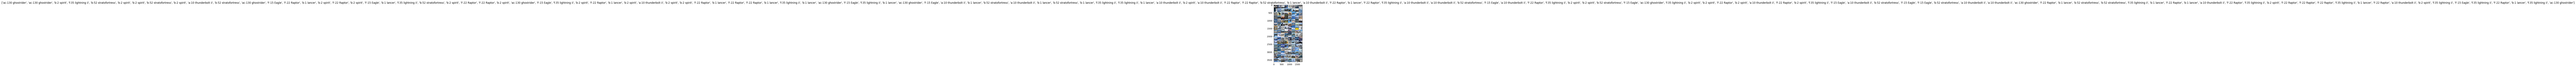

In [16]:
# test
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model=models.mobilenet_v3_large(weights=None)

In [20]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [21]:
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, len(class_names))

In [22]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [23]:
model = model.to(device)

In [24]:
criterion = nn.CrossEntropyLoss().cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.064, momentum=0.9, weight_decay=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,gamma=0.973,step_size=7)

In [25]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
Train Loss: 2.0783 Acc: 0.1359



KeyboardInterrupt



In [ ]:
visualize_model(model)

In [ ]:
torch.save(model,'models/mobilenet_custom.pt')

In [ ]:
torch.save(model.state_dict(),'models/mobilenet.pth')